In [8]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-13 04:57:11,646: Credentials are already in use. The existing account in the session will be replaced.


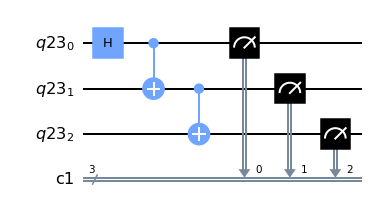

In [9]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

In [10]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'measure', 'reset', 'u2', 'u1']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


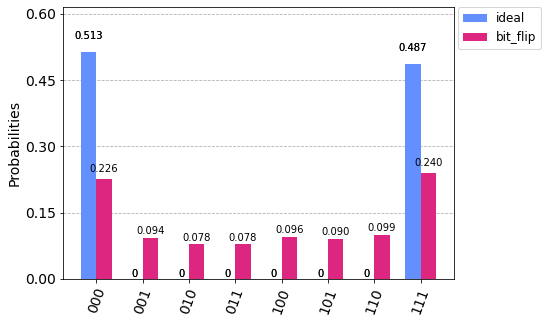

In [11]:
ideal_sim = AerSimulator()
ideal_result = ideal_sim.run(ghz_circ).result()
ideal_counts = ideal_result.get_counts()

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=bitflip_err)

# Transpile circuit for noisy basis gates
ghz_tnoise = transpile(ghz_circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(ghz_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts()

legend = ['ideal', 'bit_flip']

# Plot noisy output
plot_histogram([ideal_counts, counts_bit_flip], legend= legend)

In [12]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 3) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 3)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(3)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(3):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(3):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'measure', 'reset', 'u2']
  Qubits with noise: [0, 1, 2]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2))]


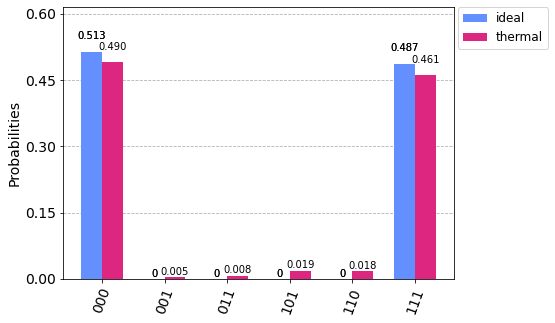

In [13]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
ghz_tthermal = transpile(ghz_circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(ghz_tthermal).result()
counts_thermal = result_thermal.get_counts()
legend_t = ['ideal', 'thermal']

# Plot noisy output
plot_histogram([ideal_counts, counts_thermal], legend= legend_t)

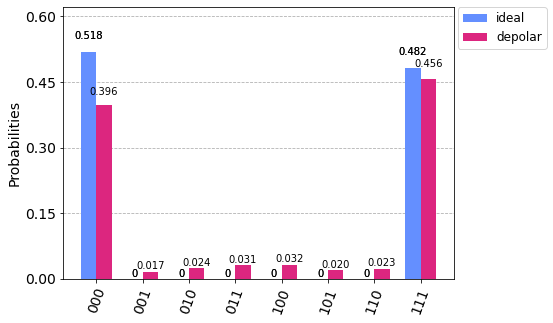

In [84]:
p_gate = 0.1
error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
error_gate1 = depolarizing_error(p_gate, 3)
error_gate2 = error_gate1.tensor(error_gate1)

noise_depolar = NoiseModel()
noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", 3)

# Run the noisy simulation
sim_depolar = AerSimulator(noise_model=noise_depolar)

# Transpile circuit for noisy basis gates
ghz_depolar = transpile(ghz_circ, sim_depolar)

# Run and get counts
result_depolar = sim_depolar.run(ghz_depolar).result()
counts_depolar = result_depolar.get_counts()
legend_t = ['ideal', 'depolar']

# Plot noisy output
plot_histogram([ideal_counts, counts_thermal], legend= legend_t)

In [83]:
print(noise_depolar)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']
